## Importing and Other Stuff

In [2]:
#!pip install tensorflow==2.5.0
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from PIL import Image
import time
import functools

In [3]:
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [4]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg

In [ ]:
content_path = '/content/Mountains-and-Forested-Valleys-in-between-scaled.jpg'
#content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
#style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'
style_path = '/content/mosaic.jpg'

weights = [0.3, 0.3, 0.2, 0.1, 0.1]
#weights = [0.6, 0.6, 0.3, 0.3, 0.3]

In [1]:
###Redundant

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def imshow(img, title=None):

  out = np.squeeze(img, axis=0)

  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [ ]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

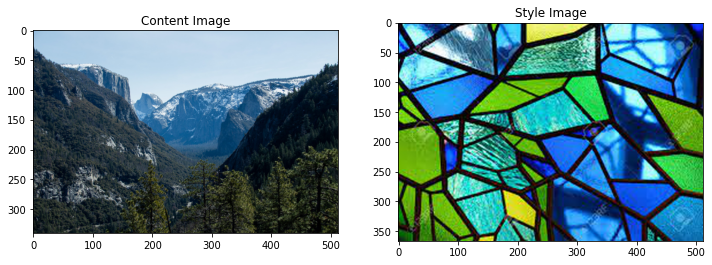

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
def resize_img(img, new_shape):
  img = np.squeeze(img, axis=0)
  img = kp_image.array_to_img(img)
  img = img.resize(new_shape, Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

Testing interpolation

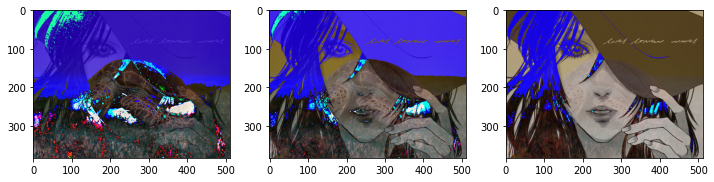

In [ ]:
####Testing Interpolation
c = (0.25 * b) + ((1-0.25) * a)
plt.subplot(1, 3, 1)
imshow(c)

c = (0.5 * b) + ((1-0.5) * a)
plt.subplot(1, 3, 2)
imshow(c)

c = (0.75 * b) + ((1-0.75) * a)
plt.subplot(1, 3, 3)
imshow(c)


In [ ]:
a = load_and_process_img(content_path)
b = load_and_process_img(style_path)
print(a.shape, b.shape)

(1, 384, 512, 3) (1, 320, 512, 3)


In [ ]:
b = resize_img(b, (a.shape[2], a.shape[1]))
a.shape, b.shape

((1, 384, 512, 3), (1, 384, 512, 3))

## Layer Selection

In [ ]:
content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Model Exploring

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

270655488/574710816 [=============>................] - ETA: 4s

KeyboardInterrupt: ignored

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('loggerhead', 0.7943018),
 ('leatherback_turtle', 0.15050052),
 ('terrapin', 0.022906618),
 ('hermit_crab', 0.013670185),
 ('mud_turtle', 0.009063428)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## Important Functions

In [5]:
def get_model():

  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
   
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
   
  model = tf.keras.Model([vgg.input], model_outputs)
  return model

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [6]:
def gram_matrix(input_tensor):
  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def get_feature_representations(model, img, type = "content"):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  
  if type == "content":
    content_outputs = model(content_image)
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return content_features

  else:
    try:
      style_outputs = model(style_image)

    except Exception:
      print('OOPS')
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    return style_features
  

In [7]:
def compute_loss(weights, model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  
  #weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style, layer_weight in zip(gram_style_features, style_output_features, weights):
    
    style_score += layer_weight * get_style_loss(comb_style[0], target_style)
    
  
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg, weights):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(weights, **cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

## Training Function

Things being tried: 

1. using resized style image
2. using image interpolation to slowly increase the amount of style content to try and preserve as much of the outlines and high level features of the content image 

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       weights,
                       num_iterations=1000,
                       plot_flag = True,
                       content_weight=1, 
                       style_weight=100): 
   
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False

  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  style_image = resize_img(style_image, (content_image.shape[2], content_image.shape[1]))

  content_features = get_feature_representations(model, content_image, "content")

  # Get the style and content feature representations (from our specified intermediate layers) 
  #style_features, content_features = get_feature_representations(model, content_path, style_path)
  #gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  
  
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=0.8, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None

  #style_features = get_feature_representations(model, style_image, "style")
  #gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  # Create a nice config 
  #loss_weights = (style_weight, content_weight)
  #cfg = {
  #    'model': model,
  #   'loss_weights': loss_weights,
  #    'init_image': init_image,
  #    'gram_style_features': gram_style_features,
  #    'content_features': content_features
  #}
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  interpolation_count = 0
  interpolation_vals = [0.0, 0.1, 0.25, 0.4, 0.50, 0.6, 0.75, 0.9, 1.0]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):

    if i<=400 and i%50 == 0:

      temp = (interpolation_vals[interpolation_count] * style_image) + ((1.0 - interpolation_vals[interpolation_count]) * content_image)
        
      style_features = get_feature_representations(model, temp, "style")
      
      gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
      loss_weights = (style_weight, content_weight)
      cfg = {
          'model': model,
          'loss_weights': loss_weights,
          'init_image': init_image,
          'gram_style_features': gram_style_features,
          'content_features': content_features
      }

      interpolation_count += 1

    grads, all_loss = compute_grads(cfg, weights)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])

    
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if plot_flag:

      if i % display_interval== 0:
        start_time = time.time()
        
        # Use the .numpy() method to get the concrete numpy array
        plot_img = init_image.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
      
  return best_img, best_loss 

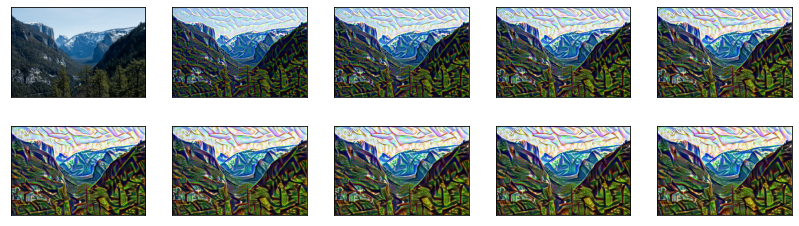

In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, weights, plot_flag = True, num_iterations=1000)

## Function to try and see the effect of different weights for layers

In [ ]:
def run_stack():
  weights_perms = [[1.0, 0.1, 0.1, 0.1, 0.1],
             [0.1, 1.0, 0.1, 0.1, 0.1],
             [0.1, 0.1, 1.0, 0.1, 0.1],
             [0.1, 0.1, 0.1, 1.0, 0.1],
             [0.1, 0.1, 0.1, 0.1, 1.0]]

  best_imgs = []
  for weight in weights_perms:
    best, best_loss = run_style_transfer(content_path, 
                                     style_path, weight, num_iterations=1000, plot_flag = False)
    
    best_imgs.append(best)

  for x,img in enumerate(best_imgs):

    plt.subplot(1,6,x+1)
    plt.title("Perm " + str(x))
    plt.axis('off')
    plt.imshow(img)



In [ ]:
run_stack()

## Displaying results

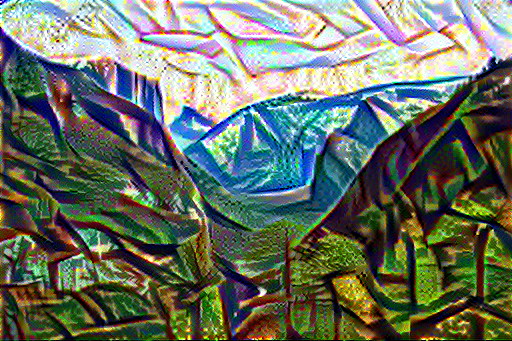

In [ ]:
Image.fromarray(best)


In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  fig = plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))
    #fig.add_subplot(2,2,1)
    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

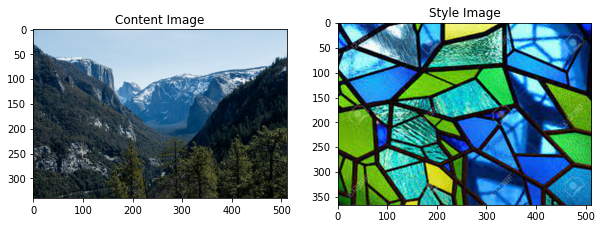

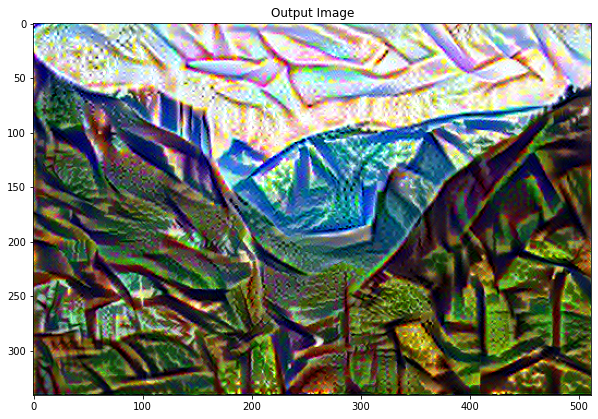

In [ ]:
show_results(best, content_path, style_path)

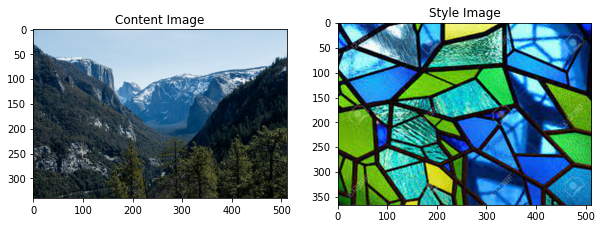

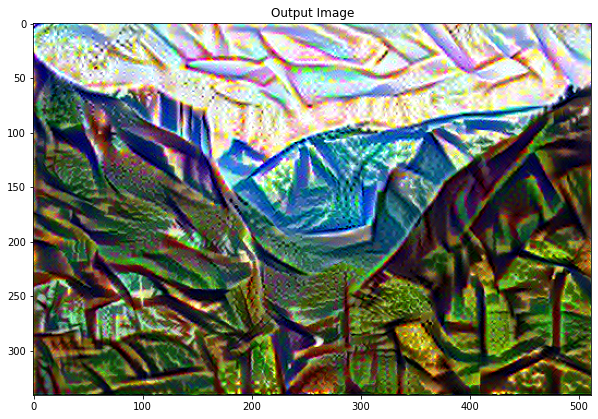

In [ ]:
show_results(best, content_path, style_path)